In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gunzip HIGGS.csv.gz
data = pd.read_csv("HIGGS.csv", header=None, nrows=1200000)
print("Loaded data shape:", data.shape)

--2025-03-31 01:23:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [   <=>              ]   2.62G  27.3MB/s    in 2m 13s  

2025-03-31 01:25:50 (20.3 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]

Loaded data shape: (1200000, 29)


In [2]:
X = data.iloc[:, 1:22].values
y = data.iloc[:, 0].values

X_train, X_test = X[:1100000], X[1100000:]
y_train, y_test = y[:1100000], y[1100000:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=512)

In [3]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=21, emb_dim=64, nhead=4, depth=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        latent = self.encoder(x).squeeze(1)
        recon = self.decoder(latent)
        out = self.classifier(latent)
        return recon, out, latent

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = TransformerAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(20):
    total_loss = 0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        recon, _, _ = model(X_batch)
        loss = loss_fn(recon, X_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}: AE Loss = {total_loss:.4f}')

Using device: cuda
Epoch 1: AE Loss = 26.9391
Epoch 2: AE Loss = 0.6692
Epoch 3: AE Loss = 0.4352
Epoch 4: AE Loss = 0.2788
Epoch 5: AE Loss = 0.2821
Epoch 6: AE Loss = 0.2170
Epoch 7: AE Loss = 0.2117
Epoch 8: AE Loss = 0.2553
Epoch 9: AE Loss = 0.1746
Epoch 10: AE Loss = 0.1825
Epoch 11: AE Loss = 0.1920
Epoch 12: AE Loss = 0.2007
Epoch 13: AE Loss = 0.1705
Epoch 14: AE Loss = 0.2152
Epoch 15: AE Loss = 0.1318
Epoch 16: AE Loss = 0.2437
Epoch 17: AE Loss = 0.1036
Epoch 18: AE Loss = 0.1221
Epoch 19: AE Loss = 0.1460
Epoch 20: AE Loss = 0.1443


In [5]:
for param in model.embedding.parameters():
    param.requires_grad = False
for param in model.encoder.parameters():
    param.requires_grad = False

clf_optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
clf_loss_fn = nn.BCEWithLogitsLoss()

model.train()
for epoch in range(20):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        clf_optimizer.zero_grad()
        _, logits, _ = model(X_batch)
        loss = clf_loss_fn(logits.squeeze(), y_batch)
        loss.backward()
        clf_optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}: Classifier Loss = {total_loss:.4f}')

Epoch 1: Classifier Loss = 1399.3053
Epoch 2: Classifier Loss = 1360.9784
Epoch 3: Classifier Loss = 1348.1576
Epoch 4: Classifier Loss = 1340.0283
Epoch 5: Classifier Loss = 1333.6777
Epoch 6: Classifier Loss = 1328.5150
Epoch 7: Classifier Loss = 1324.8012
Epoch 8: Classifier Loss = 1321.4773
Epoch 9: Classifier Loss = 1319.7626
Epoch 10: Classifier Loss = 1317.3523
Epoch 11: Classifier Loss = 1315.4938
Epoch 12: Classifier Loss = 1314.3853
Epoch 13: Classifier Loss = 1313.6477
Epoch 14: Classifier Loss = 1312.6304
Epoch 15: Classifier Loss = 1312.1768
Epoch 16: Classifier Loss = 1311.0784
Epoch 17: Classifier Loss = 1310.4038
Epoch 18: Classifier Loss = 1309.9344
Epoch 19: Classifier Loss = 1309.2975
Epoch 20: Classifier Loss = 1309.1229


ROC AUC Score = 0.7280


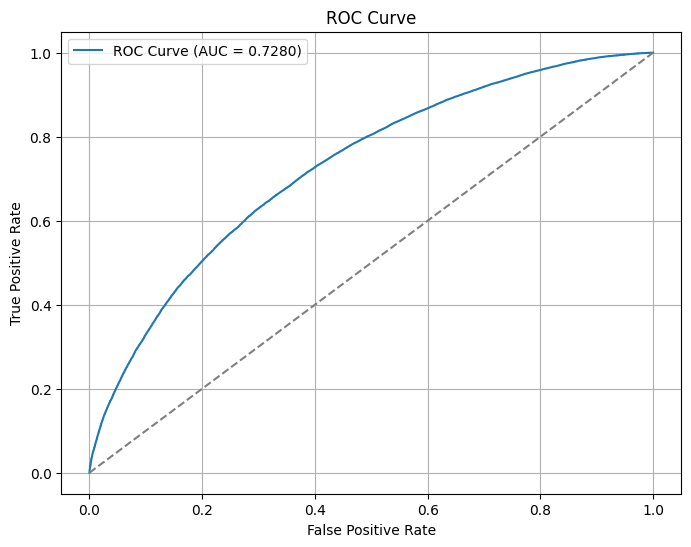

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        _, logits, _ = model(X_batch)
        all_preds.extend(torch.sigmoid(logits.squeeze()).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

auc = roc_auc_score(all_labels, all_preds)
print(f'ROC AUC Score = {auc:.4f}')

fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

#Model Selection and Optimization Discussion

**Model Selection: Transformer Autoencoder**

For this task, I implemented a lightweight Transformer Autoencoder architecture to process tabular data (21 high-level physics features). The reasons for this choice are:

1. Transformers excel at learning global dependencies through self-attention, which is beneficial for capturing relationships among different features.

2. An autoencoder structure allows us to learn compressed latent representations in an unsupervised fashion before classification.

3. A shallow encoder with 2 Transformer layers and an embedding size of 64 was used to reduce overfitting and training time, especially given the large dataset size.

Architecture summary:

Input projection: 21 → 64 via a linear layer

Encoder: 2 layers of nn.TransformerEncoderLayer (d_model=64, nhead=4)

Decoder: 64 → 128 → 21 (for reconstruction)

Classifier: 64 → 64 → 1 (for binary classification)

**Optimization Strategy**

Pretraining Phase:
I trained the autoencoder using MSE loss to reconstruct the input features. This allowed the encoder to learn meaningful latent representations of the events in an unsupervised way.

Classification Phase:
After pretraining, I froze the encoder and trained a lightweight classifier on the latent vectors using binary cross-entropy loss (BCEWithLogitsLoss).

Hardware:
I used GPU acceleration via CUDA on Google Colab to handle the large-scale dataset (~1.2M samples), significantly reducing training time.

Training Details:

Batch size: 512

Optimizer: Adam with learning rate 0.001

Pretraining epochs: 20

Classification epochs: 20